In [1]:
# Import necessary libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set matplotlib style for better visualization
sns.set(style="whitegrid")
%matplotlib inline

2. Load and Explore the Dataset

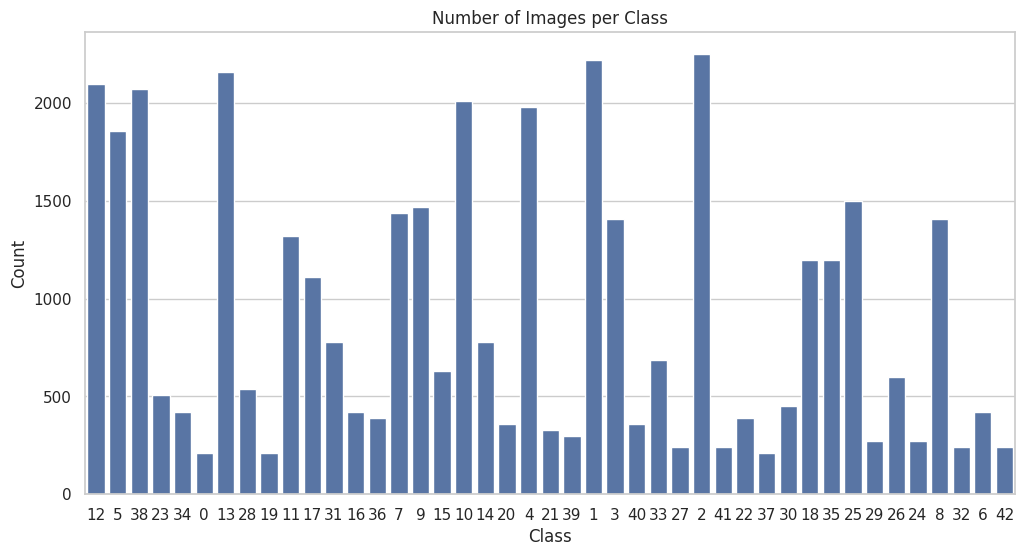

In [2]:
# Define the directory containing GTSRB dataset images
dataset_dir = "data/Train"

# Count images per class
class_counts = {}
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    if os.path.isdir(class_path):
        class_counts[class_folder] = len(os.listdir(class_path))

# Visualize the class distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

3: Display Sample Images from Each Class

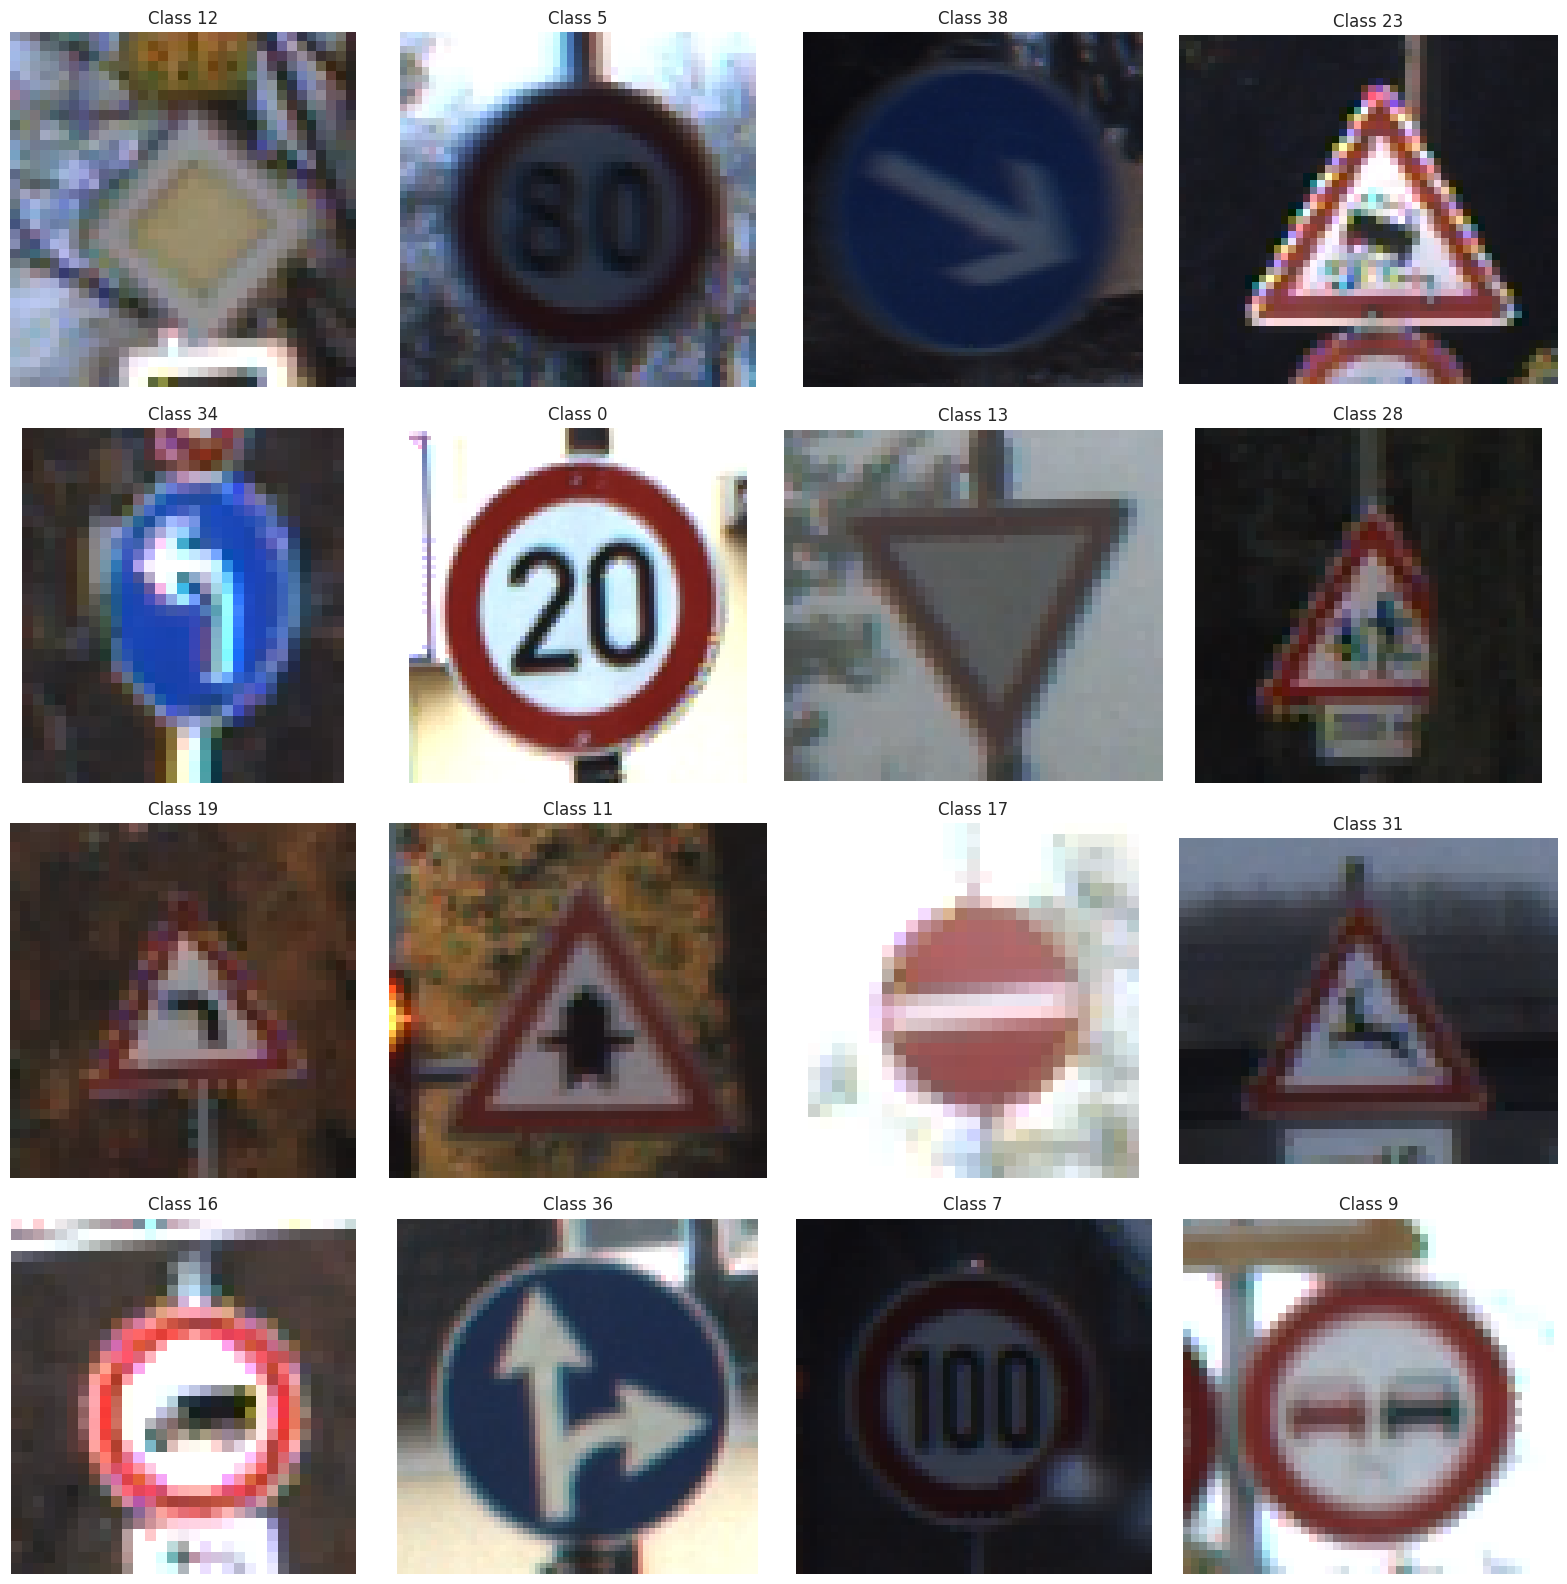

In [3]:
# Display sample images from each class
plt.figure(figsize=(16, 16))
for idx, class_folder in enumerate(os.listdir(dataset_dir)[:16]):  # Adjust range to display more or fewer classes
    class_path = os.path.join(dataset_dir, class_folder)
    sample_image_path = os.path.join(class_path, os.listdir(class_path)[0])
    sample_image = cv2.imread(sample_image_path)
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    plt.subplot(4, 4, idx + 1)
    plt.imshow(sample_image)
    plt.title(f"Class {class_folder}")
    plt.axis("off")
plt.tight_layout()
plt.show()

4. Feature Extraction using SIFT

In [4]:
# Initialize SIFT
sift = cv2.SIFT_create()

# Lists to hold SIFT descriptors and labels
descriptors_list = []
labels = []

# Loop through each image and extract SIFT descriptors
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
            keypoints, descriptors = sift.detectAndCompute(image, None)
            if descriptors is not None:
                descriptors_list.append(descriptors)
                labels.append(int(class_folder))  # Assuming folder name is the class label

# Stack all descriptors and convert labels to a numpy array
all_descriptors = np.vstack(descriptors_list)
labels = np.array(labels)
print("Total descriptors shape:", all_descriptors.shape)

Total descriptors shape: (911972, 128)


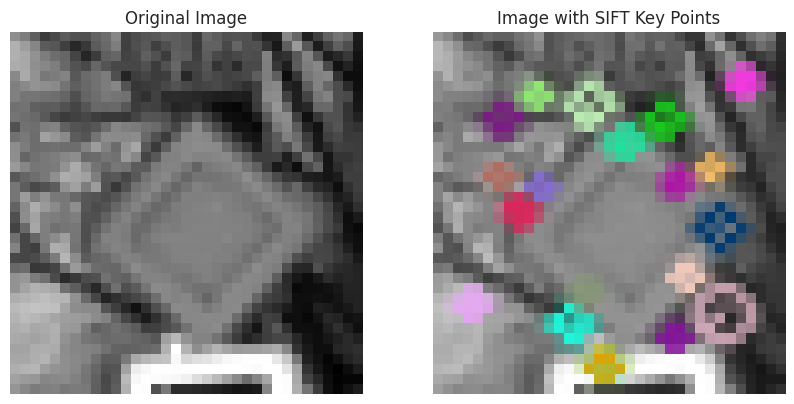

Number of key points detected: 20


In [5]:
# Select a sample image from the dataset
sample_image_path = os.path.join(dataset_dir, os.listdir(dataset_dir)[0], os.listdir(os.path.join(dataset_dir, os.listdir(dataset_dir)[0]))[0])
sample_image = cv2.imread(sample_image_path, cv2.IMREAD_GRAYSCALE)

# Detect SIFT key points and descriptors
keypoints, descriptors = sift.detectAndCompute(sample_image, None)

# Draw key points on the image
image_with_keypoints = cv2.drawKeypoints(sample_image, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Plot the original image and the image with SIFT key points
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image, cmap='gray')
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(image_with_keypoints, cmap='gray')
plt.title("Image with SIFT Key Points")
plt.axis("off")
plt.show()

print(f"Number of key points detected: {len(keypoints)}")

5. Bag of Visual Words (BoVW) with KMeans

In [6]:
# Define the number of visual words
num_clusters = 400

# Cluster SIFT descriptors using KMeans
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(all_descriptors)

# Helper function to create histograms of visual words
def build_histogram(descriptors, kmeans):
    histogram = np.zeros(num_clusters)
    cluster_assignments = kmeans.predict(descriptors)
    for i in cluster_assignments:
        histogram[i] += 1
    return histogram

# Create histograms for each image
histograms = [build_histogram(des, kmeans) for des in descriptors_list]

# Convert histograms and labels to numpy arrays for model training
X = np.array(histograms)
y = labels

6. Train-Test Split and Model Training (SVM Classifier)

Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.61      0.78      0.68        50
           1       0.70      0.72      0.71       425
           2       0.71      0.69      0.70       417
           3       0.58      0.58      0.58       259
           4       0.64      0.64      0.64       330
           5       0.61      0.63      0.62       323
           6       0.71      0.62      0.66        76
           7       0.70      0.68      0.69       280
           8       0.55      0.53      0.53       219
           9       0.78      0.75      0.77       282
          10       0.72      0.72      0.72       300
          11       0.76      0.86      0.81       235
          12       0.65      0.74      0.69       384
          13       0.64      0.70      0.67       434
          14       0.74      0.79      0.77       168
          15       0.57      0.52      0.54       128
          16       0.68      0.79      0.73        72
          17

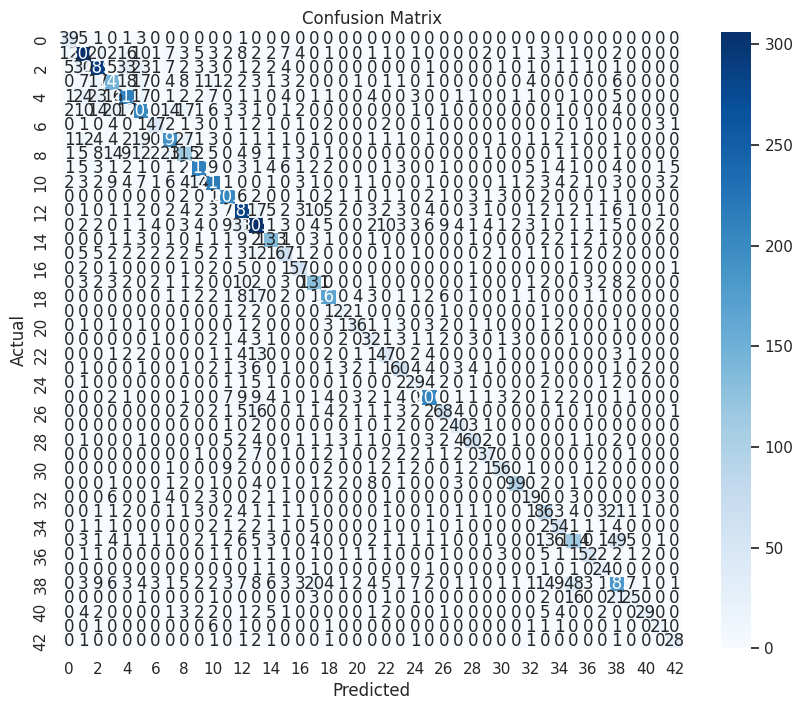

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with SVM classifier
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', C=1))

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions and evaluate the classifier
y_pred = clf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [8]:
def predict_image(image_path, kmeans, clf):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = sift.detectAndCompute(image, None)
    if descriptors is not None:
        histogram = build_histogram(descriptors, kmeans).reshape(1, -1)
        prediction = clf.predict(histogram)
        return prediction[0]
    else:
        return None

# Example usage
new_image_path = "data/meta/37.png"
prediction = predict_image(new_image_path, kmeans, clf)
print(f"Predicted class for new image: {prediction}")

Predicted class for new image: 37
